# A5

In [1]:
# Standard Imports
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

import Network as NN
import importlib
import mnist_loader

import copy
import random

# Q1: Electrophysiology Experiment

In [2]:
import lif

def MonkeyFixationSpikes(x, T, pop):
    """
    spike_times = MonkeyFixationSpikes(x, T, pop)

    Given the gaze direction, outputs the spiking activity of the monkey's
    neurons.

    Input:
      x is the monkey's gaze direction
      T is the duration of the fixation (in seconds)
      pop is a 6xN matrix of LIF parameters

    Output:
      spike_times is an list containing N arrays of time-stamps indicating
        when each neuron fired.  
    """
    dt = 0.001  # time-step size for simulations
    xts = x*np.ones(int(T/dt))
    sp, v = lif.Stim2Spikes(xts, dt, pop, interp=True)
    return sp

In [3]:
#=====================
# CHOOSE A MONKEY
# The monkey's are numbered 0, 1, 2, 3, and 4.
# This will read in the LIF parameters for the monkey's neurons
# as well as the spiking trains for the unknown sequence.
#=====================
infile = open('monkey3.npz', 'rb')
varsin = np.load(infile)
pop = varsin['pop']   # parameters for population of neurons
Asp = varsin['Asp']   # spike trains for unknown sequence
N = len(pop[1])  # number of neurons

## (a) Behavioural Sampling Experiment

In [4]:
# Select a spread of stimulus values from 0 to 9. Choose at least 100 samples.

# ***** YOUR CODE HERE *****
# gaze directions
X = [d for d in np.arange(0, 9.01, 9.01/100)]
X[99] = 9.0

# fixation duration is 0.4 seconds
T = 0.4

# array to hold output
A = []

# run the simulation over all gaze directions - divide by 0.4 to convert to Hz
for x in X:
    st = MonkeyFixationSpikes(x, T, pop)
    A.append(lif.CountSpikes(st, 0.0, 0.4) / 0.4)

A = np.array(A)

X = np.array(X)

## (b) View Tuning Curves

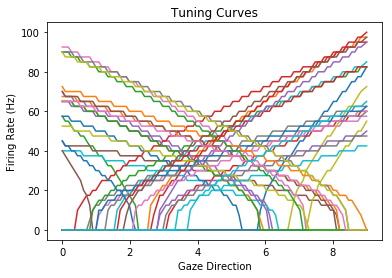

In [5]:
# ***** YOUR CODE HERE *****

# plot
plt.figure()
plt.plot(X, A)
plt.title('Tuning Curves')
plt.ylabel('Firing Rate (Hz)')
plt.xlabel('Gaze Direction');

## (c) Compute the Decoding Weights

In [6]:
# ***** YOUR CODE HERE *****

pseudo_inv_A = np.dot( np.linalg.inv(np.dot(A.T, A)), A.T)

D = np.dot(pseudo_inv_A, X)

# confirm D is a 40 x 1 vector matrix
print(np.shape(D))

# confirm A*D closely resembles X (our gaze directions)
print(np.dot(A, D))

(40,)
[0.11381397 0.15397562 0.18801522 0.21648097 0.23862432 0.45063566
 0.50442036 0.62294233 0.7089269  0.76647237 0.9737212  0.97270155
 1.11593814 1.18870399 1.23254774 1.37036435 1.47885159 1.46205644
 1.6142892  1.68853745 1.80579898 1.89614848 2.01859392 2.07200735
 2.1533338  2.2706713  2.30326766 2.45167693 2.49250392 2.59358333
 2.7071193  2.77615875 2.91996858 2.97923768 3.01971272 3.18825869
 3.23331546 3.30803403 3.43170026 3.50371622 3.58378894 3.66572848
 3.81044436 3.91788303 4.03058957 4.11650601 4.10655118 4.28841558
 4.37783731 4.4039092  4.49875698 4.59293988 4.6699094  4.8208474
 4.81002231 4.91044249 5.04111089 5.08960959 5.23660438 5.3970217
 5.39755912 5.53886739 5.55192456 5.64198319 5.7021012  5.80825851
 5.9842508  6.0153141  6.15101803 6.24867363 6.32948712 6.36944055
 6.50417938 6.53864989 6.65805788 6.73334614 6.86549439 6.97182991
 7.03939768 7.10792944 7.20303502 7.23906984 7.37627678 7.49480847
 7.57786566 7.68602117 7.78676993 7.82785259 7.93016258 8.

## (d) View Spike Raster of Unknown Sequence

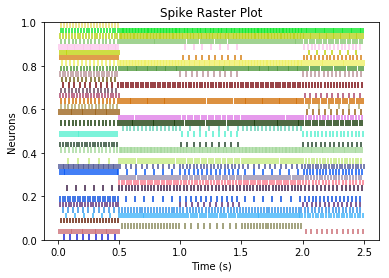

In [7]:
# Plot Spike Raster of unknown sequence
lif.PlotSpikeRaster(Asp)
plt.title('Spike Raster Plot')
plt.ylabel('Neurons')
plt.xlabel('Time (s)');

## (e) Decode the Unknown Code

In [8]:
# Spike trains for unknown sequence are stored in 'Asp'
# Asp is a list of arrays of spike trains, one array per neuron.

In [9]:
# Compute firing rates
B = []
for i in range(0,5):
    # get start and end time for the interval
    start_time = 0.5 * i
    end_time = start_time + 0.5
    # determine firing rates over each interval (rate = number of spikes / time)
    B.append(lif.CountSpikes(Asp, start_time, end_time) / 0.5)

# convert list of arrays into numpy array
B = np.array(B)

In [10]:
# Decode unknown code
code= []
for interval in B:
    decoded_val = np.dot(interval, D)
    print(decoded_val)
    code.append(decoded_val)
    
code = np.array(code)

6.046952193476633
1.0300997264717426
2.1082685373716044
1.0441816475524721
3.132842868341011


## (f) Display the Unknown Code

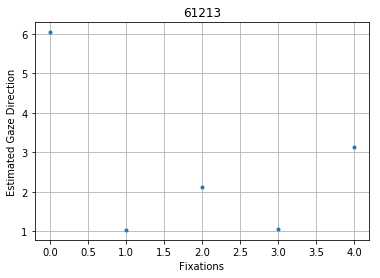

In [11]:
plt.figure()
plt.grid(True)
plt.plot(code,'.')
plt.title('61213')
plt.ylabel('Estimated Gaze Direction')
plt.xlabel('Fixations');

# Q2: LSTM

In [12]:
# Connection Weights
wf = [0, 8, 0, 0]
bf = -4

wi = [0, 0, 9, 0]
bi = -4.5

wo = [0, 0, 0, 10]
bo = -5

wc = [1, 0, 0, 0]
bc = 0

# Initial State
h0 = [0.05]
c0 = -0.02

def ComputeAndPrintValues(xt):
    # calculate ft, it, ot
    vt = h0 + xt

    ft = logistic(np.dot(wf, vt) + bf)
    it = logistic(np.dot(wi, vt) + bi)
    ot = logistic(np.dot(wo, vt) + bo)

    result = (ft, it, ot)

    print( "(ft, it, ot) = " + str(result))

    # calculate ct and ht
    c_hat_t = np.tanh(np.dot(wc, vt) + bc)
    ct = ft * c0 + it * c_hat_t

    ht = ot * np.tanh(ct)

    print("ct = " + str(ct))
    print("ht = " + str(ht))

def logistic(z):
    return 1 / (1 + np.exp(-z))

## (a)

### (i)

In [13]:
# part i
print( "part i:" )
xt = [1, 0, 0]
ComputeAndPrintValues(xt)

part i:
(ft, it, ot) = (0.9820137900379085, 0.01098694263059318, 0.0066928509242848554)
ct = -0.01909138600117828
ht = -0.00012776027875546997


$C_t$ is almost the same as $C_0$ (-0.02) because:
$$
C_t = f_t \odot C_0 + i_t \odot \tilde{C_t}
$$
and we can see $f_t \approx 1$ and $i_t \approx 0$, causing it to remain nearly unchanged.

$h_t$ is almost zero because:
$$
h_t = o_t \odot tanh(C_t)
$$
and our output gate $o_t$ is nearly zero.


### (ii)

In [14]:
# part ii
print( "part ii:" )
xt = [0, 1, 0]
ComputeAndPrintValues(xt)

part ii:
(ft, it, ot) = (0.01798620996209156, 0.9890130573694068, 0.0066928509242848554)
ct = 0.049049760959058254
ht = 0.00032801972156155


Here our forget gate, $f_t$, is very small, so the old value of $C_0$ is a very small factor.
$i_t \approx 1$, causing $\tilde{C_t}$ to be the biggest influence on $C_t$.

$$
\tilde{C_t} = tanh( W_c v_t + b_c)
$$

tanh is almost linear for small values, and we know our result is near zero, so let's simplify by removing tanh. We also know $b_c = 0$, so we can remove that as well. Substitute in $W_c$ and $v_t$ and we get:

$$
\tilde{C_t} \approx W_c v_t\\
= [1, 0, 0, 0] \odot [h_0, 0, 1, 0]\\
= h_0
$$

Which is why $C_t$ is almost exactly the same as our previous h value, 0.05.

As for $h_t$, yet again, $o_t$ is very small, so the new value for h is again dimished for the same reason as in part i.

### (iii)

In [15]:
# part iii
print( "part iii:" )
xt = [1, 0, 1]
ComputeAndPrintValues(xt)

part iii:
(ft, it, ot) = (0.9820137900379085, 0.01098694263059318, 0.9933071490757153)
ct = -0.01909138600117828
ht = -0.018961306577925104


Similar to part i, $f_t \approx 1$ and $i_t \approx 0$, causing $C_t$ to be about the same as $C_0$, -0.02.

Since $o_t \approx 1$ and

$$
h_t = o_t \odot tanh(C_t)
$$

We can see why $h_t$ is almost the same as $C_t$, because tanh is almost linear for values near zero.

## (b)

In [16]:
print("First solution:")
xt = [1, 1, 1]
ComputeAndPrintValues(xt)

print("Second solution:")
xt = [1, 1, 0]
ComputeAndPrintValues(xt)

First solution:
(ft, it, ot) = (0.9820137900379085, 0.9890130573694068, 0.9933071490757153)
ct = 0.029769209357541914
ht = 0.02956123654636938
Second solution:
(ft, it, ot) = (0.9820137900379085, 0.9890130573694068, 0.0066928509242848554)
ct = 0.029769209357541914
ht = 0.00019918204507686518


Two solutions exist, $[1, 1, 0]$ and $[1, 1, 1]$, both produce $C_t \approx 0.03 = 0.05 + -0.02$ as required.

Recall from question a part ii) that $\tilde{C_t} \approx h_0$. Knowing this, and given the formula for $C_t$ below, we can see we desire $f_t$ and $i_t$ to both be approximately 1 in order to sum $C_0$ and $h_0$.

$$
C_t = f_t \odot C_0 + i_t \odot \tilde{C_t}
$$

Since $f_t$ is largely dependent on $W_f \odot v_t$ and $W_f = [0, 8, 0, 0]$, the first column of $x_t$ is the only one of consequence since it will become the second column of $v_t$ and the rest get zeroed out. A value of 1 produces an $f_t \approx 1$ as desired.

Similar reasoning shows why we want the second column of $x_t$ to be 1, since $W_i = [0,0,9,0]$.

The last column affects $h_t$ which isn't of consequence for this question.

## (c)

In [17]:
xt = [0.5, 0.5, 1]
ComputeAndPrintValues(xt)

(ft, it, ot) = (0.5, 0.5, 0.9933071490757153)
ct = 0.014979187478939988
ht = 0.014877821284526208


Desired average is $\frac{0.05 + (-0.02)}{2} = 0.015$, which is comparable to the output given above.

For the same reasoning as before, we know that if $f_t$ and $i_t$ are 0.5, then $C_t$ will be approximately half the sum of $C_0$ and $h_0$, which is to say their average.

And also as explained before, if $o_t \approx 1$ then $h_t \approx C_t$, as desired.

This leads us to the conclusion that $[0.5, 0.5, 1]$ produces the desired result.

# Q3: Adversarial Inputs

## Load data, get trained network, etc.

In [18]:
# Load MNIST
train, validate, test = mnist_loader.load_data_wrapper()
train_in = np.array(train[0])
train_out = np.array(train[1])

In [19]:
# You can create and train your own Network on MNIST.
# You can save it like this...
#net.Save('blah.npy')

In [20]:
# Or, you can load the pretrained Network object from the supplied file,
# like this...
net = NN.Network()
net.Load('MNIST_trained_784-100-100-10.npy')

In [21]:
test_ac = NN.ClassificationAccuracy(net.FeedForward(test[0]), test[1])
print('Testing Accuracy = '+str(test_ac*100)+'%')

train_ac = NN.ClassificationAccuracy(net.FeedForward(train[0]), train[1])
print('Training Accuracy = '+str(train_ac*100)+'%')

Testing Accuracy = 97.53%
Training Accuracy = 99.136%


In [22]:
#Extract 10 digits from MNIST classified correctly by the network
x_image = []
x_class = []
for i in range(0, 10):
    while True:
        j = random.randint(0, len(test[0]))
        if np.argmax(test[1][j]) == i:
            r = net.FeedForward([test[0][j]])
            if np.argmax(r) == i:
                x_image.append(test[0][j])
                x_class.append(test[1][j])
                break

## (a) GradientInput

In [23]:
def GradientInput(net, x, t):
    '''
        dEdx = Input_Gradient_Ascent(net, x, t)

        Computes dEdx for a network given input x and target t.
        The cost function is specified by the network.

        Inputs:
          net is the neural network
          x is the input that you want to perturb
          t is the corresponding true target vector (one-hot)
        
        Output:
          dEdx is a vector the same shape as x
    '''

    # ***** YOUR CODE HERE *****
    
    # Do forward pass to generate node activities and activation levels
    net.FeedForward([x])
    
    # NOTE: Much of this code is taken from Network.py's BackProp() function.
    t = np.array([t])  # convert t to an array, in case it's not
                
    # Error gradient for top layer
    dEdz = net.TopGradient(t) 

    # Loop down through the layers
    for i in range(net.n_layers-2, -1, -1):
        pre = net.lyr[i]

        # If not the bottom layer,
        # Project error gradient down to layer below
        if i>0:
            dEdz = ( dEdz @ net.W[i].T ) * pre.sigma_z_p(pre.z)
        # If bottom layer, project gradient to inputs
        else:
            dEdz = dEdz @ net.W[i].T

    # sum over results, in case of batch testing
    dEdx = np.sum(dEdz, axis=0)
    
    return dEdx

## (b) FGSM

In [24]:
def FGSM(net, x_input, x_class, ep=0.05, it_lim=100000, conf=0.5, targ=False):
    '''
        x_adv = FGSM(net, x_input, x_class, ep=0.05, it_lim=100000, conf=0.5)
        
        Performs the Fast Gradient Sign Method, perturbing each input until it
        is misclassified with the specified confidence, or reaches the maximum
        number of iterations.
        
        Inputs:
          net is the Network object
          x_input is a batch of inputs
          x_class is the corresponding one-hot class vectors
          ep is the perturbation step for the FGSM
          it_lim is the maximum number of iterations
          conf is the desired confidence for the misclassification
          targ is Boolean, indicating if the FGSM is targetted
             if targ is False, then x_class is considered to be the true
             class of the input, and FGSM will work to increase the cost
             if targ is True, then x_class is considered to be the target
             class for the perturbation, and FGSM will work to decrease the cost
        
        Output:
          x_adv is a batch of adversarial inputs, the same size as x_input
    '''

    # ***** YOUR CODE HERE *****
    
    x_adv = []
    
    for xin, cls in zip(x_input, x_class):

        # create working copy of input image
        xadv = copy.deepcopy(xin)

        # determine gradient w.r.t. target class
        gradients = GradientInput(net, xadv, cls)

        # get signs of gradient
        signs = np.sign(gradients)

        # determine the index of the target output we wish to change
        class_index = int(np.where(cls == 1.)[0]) # index 0 because np.where() produces a list of locations of 1.
    
        # Try to get the network to give x_class as the correct response
        if targ:
            # iterate until goal or iteration limit is reached
            for i in range(it_lim):
                # reduce cost
                xadv -= ep * signs
                
                # do feed forward to see network's classification
                output = net.FeedForward([xadv])[0] # index 0 because net.FeedForward() produces a matrix

                # check if confidence of false class is above threshold
                if output[class_index] >= conf:
                    x_adv.append(xadv)
                    break
                

        # Try to get the network to NOT give x_class as the correct response
        else:
            # iterate until goal or iteration limit is reached
            for i in range(it_lim):
                # increase cost
                xadv += ep * signs

                # do feed forward to see network's classification
                output = net.FeedForward([xadv])[0] # index 0 because net.FeedForward() produces a matrix

                # check if confidence of correct class is below threshold
                if output[class_index] <= conf:
                    x_adv.append(xadv)
                    break

    return np.array(x_adv)

## (c) Untargetted Adversarial Perturbation

Verifying network is correctly trained
Digit 0 is classified as 0 with classification value 0.9991037872837192
Digit 1 is classified as 1 with classification value 0.9990988026536692
Digit 2 is classified as 2 with classification value 0.9999938640292877
Digit 3 is classified as 3 with classification value 0.9994902206369465
Digit 4 is classified as 4 with classification value 0.9999390525793228
Digit 5 is classified as 5 with classification value 0.9999067186175812
Digit 6 is classified as 6 with classification value 0.9996401538075848
Digit 7 is classified as 7 with classification value 0.9990050010582784
Digit 8 is classified as 8 with classification value 0.8488647713130507
Digit 9 is classified as 9 with classification value 0.9991431586415056

Checking results of adversarial inputs
Digit 0 is classified as 2 with classification value 0.9614221238785663
Digit 1 is classified as 8 with classification value 0.7252999371059868
Digit 2 is classified as 3 with classification value 0.96

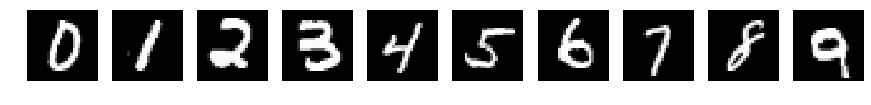

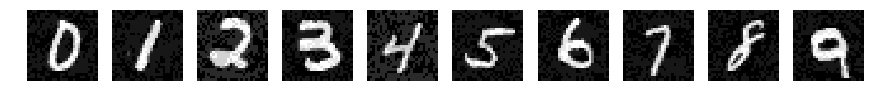

In [25]:
# returns the index, and the value of the maximum value in the array
def GetClass(array):
    index = np.where(array == np.amax(array))[0][0]
    value = array[index]
    return index, value

# this helper function just makes the code below more readible
def PrintClassifications(net, images, classifications):
    for image, classification in zip(images, classifications):
        # produce the output of the network
        net_out = net.FeedForward([image])[0]

        # get index and value according to the classification
        ind_c, val_c = GetClass(classification)

        # get index and value according to the network's output
        ind_n, val_n = GetClass(net_out)

        # print result
        print("Digit " + str(ind_c) + " is classified as " + str(ind_n) + " with classification value " + str(val_n))
    print()

# make a new list of adversarial images based off the original images
x_adv = FGSM(net, x_image, x_class, targ=False)    

# Ensure original images are correctly classified
print("Verifying network is correctly trained")
PrintClassifications(net, x_image, x_class)

# Ensure adversarial images are INCORRECTLY classified
print("Checking results of adversarial inputs")
PrintClassifications(net, x_adv, x_class)

# plot originals
plt.figure(figsize=[15,4])
n_digits = 10
for n in range(n_digits):
    plt.subplot(2,n_digits,n+1)
    plt.imshow(np.reshape(x_image[n], [28,28]), cmap='gray');
    plt.axis('off');
plt.show()

# plot adversarial images
plt.figure(figsize=[15,4])
n_digits = 10
for n in range(n_digits):
    plt.subplot(2,n_digits,n+1)
    plt.imshow(np.reshape(x_adv[n], [28,28]), cmap='gray');
    plt.axis('off');
plt.show()

## (d) Targetted Adversarial Perturbation

perturbed 5 classified as 3 with classification value 0.9972628771190649
perturbed 1 classified as 2 with classification value 0.9954392088208522
perturbed 7 classified as 4 with classification value 0.922402106088958


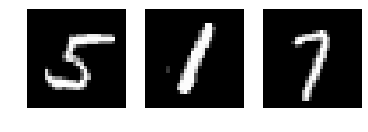

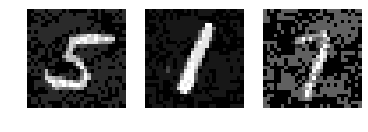

In [26]:
# Choose correctly classified images (originally part of MNIST test set)
originals = [x_image[5], x_image[1], x_image[7]]

# Build false targets
targets = []
for i in [3, 2, 4]:
    array = np.zeros(10, dtype=float)
    array[i] = 1.0
    targets.append(array)

# create adversarial images
x_adv = FGSM(net, originals, targets, ep=0.05, it_lim=100000, conf=0.8, targ=True)

# display their classifications and values according to the network
for img, cls in zip(x_adv, [5, 1, 7]):
    net_out = net.FeedForward([img])[0]
    net_i, net_v = GetClass(net_out)
    print("perturbed " + str(cls) + " classified as " + str(net_i) + " with classification value " + str(net_v))

# plot originals
plt.figure()
n_digits = 3
for n in range(n_digits):
    plt.subplot(2,n_digits,n+1)
    plt.imshow(np.reshape(originals[n], [28,28]), cmap='gray');
    plt.axis('off');
plt.show()

# plot adversarial images
plt.figure()
n_digits = 3
for n in range(n_digits):
    plt.subplot(2,n_digits,n+1)
    plt.imshow(np.reshape(x_adv[n], [28,28]), cmap='gray');
    plt.axis('off');
plt.show()